In [1]:
import pandas as pd
import torch, os
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

# Set the TRANSFORMERS_CACHE environment variable to a writable directory
#os.environ['TRANSFORMERS_CACHE'] = "C:\\Users\\vange\OneDrive\Desktop\\reddit-sentiment-analysis\\mcu-sentiment-analysis\\hf-dir"

In [2]:
# check if GPU is available
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

### Data Preprocessing

Data: Twitter sentiment analysis data from [Kaggle](https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset), with 3 classes; Negative, Positive, Neutral

In [3]:
# for Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df1 = pd.read_csv('/content/drive/MyDrive/model-finetuning/data/train.csv')

df2 = pd.read_csv('/content/drive/MyDrive/model-finetuning/data/test.csv')

df = pd.concat(
    (df1,
     df2
     )
    )[['textID', 'text', 'sentiment']]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     31015 non-null  object
 1   text       31014 non-null  object
 2   sentiment  31015 non-null  object
dtypes: object(3)
memory usage: 1009.2+ KB
None


,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative


In [5]:
# remove rows with missing values
df = df.dropna()

In [6]:
# checking for duplicates
df['textID'].duplicated().sum()

0

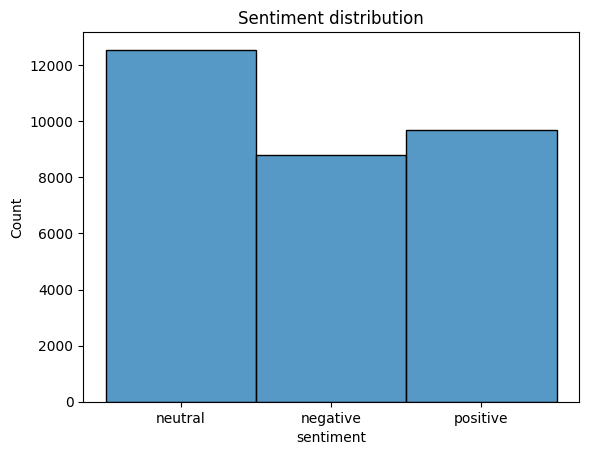

In [7]:
df['sentiment'].value_counts()
#plotting the sentiment distribution
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(df['sentiment'])
plt.title('Sentiment distribution')
plt.show()


In [8]:
# get labels
labels = (df['sentiment']
          .apply(lambda x: x.strip())
          .unique()
          .tolist()
          )

# make id2label, label2id
NUM_LABELS = 3
id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

print(id2label)
print()
print(label2id)

{0: 'neutral', 1: 'negative', 2: 'positive'}

{'neutral': 0, 'negative': 1, 'positive': 2}


In [9]:
# add label_id to the dataframe
df.loc[:, 'label'] = df['sentiment'].apply(lambda x: label2id[x.strip()])
df.head(5)

,textID,text,sentiment,label
0,cb774db0d1,"I`d have responded, if I were going",neutral,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,1
2,088c60f138,my boss is bullying me...,negative,1
3,9642c003ef,what interview! leave me alone,negative,1
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,1


In [10]:
# set tokenizer
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME,
                                                      num_labels=NUM_LABELS,
                                                      id2label=id2label,
                                                      label2id=label2id
                                                      )
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
# split the data to train and validation
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.20, random_state=42)

train_texts = train_df['text'].tolist()
val_texts = val_df['text'].tolist()

train_labels = train_df['label'].tolist()
val_labels = val_df['label'].tolist()

In [13]:
# apply tokenizer to the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)

In [14]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [15]:
# Create DataLoader instances for the training and validation data
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

### Model Training

In [16]:
from transformers import Trainer, TrainingArguments

In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [18]:
# Define the training arguments
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='/content/drive/MyDrive/model-finetuning/Testmodel_concat_data',
    #output_dir='./TestModel',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='/content/drive/MyDrive/model-finetuning/training-logs_concat_data',
    #logging_dir='./training-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [20]:

trainer.train()

# save the model
model_path = '/content/drive/MyDrive/model-finetuning/finetuned_model'
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.178600,1.045113,0.504272,0.438335,0.531134,0.464652
100,0.919500,0.705654,0.704498,0.708820,0.727943,0.724196
150,0.683700,0.661925,0.732226,0.735707,0.739914,0.732642
200,0.704100,0.689242,0.728680,0.730675,0.732652,0.741038
250,0.653100,0.661762,0.739965,0.742652,0.742288,0.746460
300,0.666100,0.639469,0.756569,0.759216,0.758728,0.762452
350,0.617800,0.614353,0.767532,0.770580,0.783897,0.762671
400,0.597400,0.616648,0.764146,0.766018,0.765583,0.771354
450,0.584400,0.573506,0.769628,0.771352,0.793638,0.760562
500,0.578300,0.537178,0.784620,0.787731,0.788244,0.787236


TrainOutput(global_step=4653, training_loss=0.4067765460164476, metrics={'train_runtime': 1227.8732, 'train_samples_per_second': 60.619, 'train_steps_per_second': 3.789, 'total_flos': 4207568969516220.0, 'train_loss': 0.4067765460164476, 'epoch': 3.0})

### Model Evaluation

In [22]:
# LOAD MODEL
# load the model
model_path = '/content/drive/MyDrive/model-finetuning/finetuned_model'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

# pipeline
nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=0)

In [23]:
nlp("great!")

[{'label': 'positive', 'score': 0.98912513256073}]

In [27]:
# save train and test data
train_df.to_csv('/content/drive/MyDrive/model-finetuning/train_df.csv')
val_df.to_csv('/content/drive/MyDrive/model-finetuning/test_df.csv')

In [29]:
# evaluate the model
test_df = pd.read_csv('/content/drive/MyDrive/model-finetuning/test_df.csv')[['text', 'sentiment']]
print(test_df.info())
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6203 entries, 0 to 6202
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       6203 non-null   object
 1   sentiment  6203 non-null   object
dtypes: object(2)
memory usage: 97.0+ KB
None


,text,sentiment
0,I was afraid you were going to say that.,negative
1,part 2: social networking??.. there is even r...,neutral
2,i miss the one who would do anything to spend ...,negative
3,tee we beefin....what was u supposed to do b...,neutral
4,Happy Hug Your Mom Day!! love you mom,positive


In [30]:
# get the real labels
id2label = {0: 'neutral', 1: 'negative', 2: 'positive'}
label2id = {'neutral': 0, 'negative': 1, 'positive': 2}

y_true = test_df['sentiment'].apply(lambda x: label2id[x.strip()]).tolist()

In [31]:
# get the predicted labels
y_pred = []
for text in test_df['text']:
    pred = nlp(text)[0]
    y_pred.append(label2id[pred['label']])

# calculate the accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
accuracy = accuracy_score(y_true, y_pred)
f1_score = precision_recall_fscore_support(y_true, y_pred, average='macro')[2]

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1_score:.2f}')

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Accuracy: 0.78
F1 Score: 0.79


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=id2label.values()))

              precision    recall  f1-score   support

     neutral       0.72      0.80      0.76      2502
    negative       0.84      0.71      0.77      1749
    positive       0.83      0.84      0.83      1952

    accuracy                           0.78      6203
   macro avg       0.80      0.78      0.79      6203
weighted avg       0.79      0.78      0.78      6203

